In [3]:
import json
import os
from os.path import basename, exists
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
from matplotlib.colors import ListedColormap
from queue import PriorityQueue


In [4]:
# Load the data from MITRE ATT&CK softwares (https://attack.mitre.org/software/)
with open('../software_techniques.json') as f:
    software_techniques = json.load(f)

In [25]:

# Load the data from the tactics json file
with open('../tactics_techniques.json') as f:
    tactics_data = json.load(f)

# Convert tactics data to a dictionary
tactics_dict = {}
step = 0 # The step of the tactic. Used to sort techniques later.
for item in tactics_data:
    visited = False
    for technique in item["techniques"]:
        visited = True
        tactics_dict[technique["id"]] = (step, item["tactic"])
    if visited:
        step += 1
max_step = step-1

In [6]:
# Maps to store nodes of each tactic
tactics = {
    'Start': set(),
    'Initial Access': set(),
    'Execution': set(),
    'Persistence': set(),
    'Privilege Escalation': set(),
    'Defense Evasion': set(),
    'Credential Access': set(),
    'Discovery': set(),
    'Lateral Movement': set(),
    'Collection': set(),
    'Command and Control': set(),
    'Exfiltration': set(),
    'Impact': set(),
    'End': set(),
}

colors = ['gold', 'red', 'orange', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue', 'purple', 'violet', 'deeppink', 'brown', 'pink', 'grey']

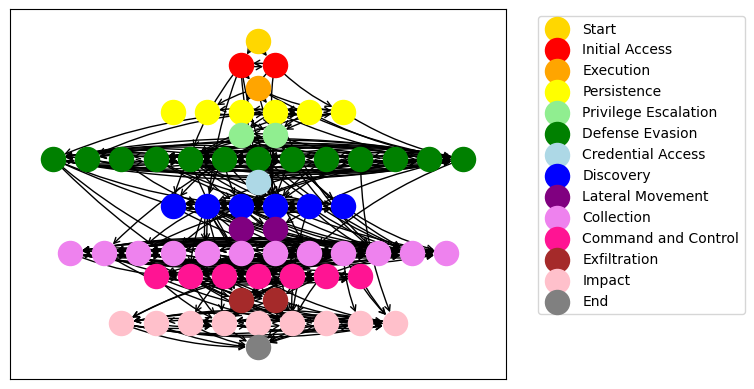

In [7]:
G = nx.DiGraph()
G.add_node('Start', tactic='Start', step=0)
tactics['Start'].add('Start')

G.add_node('End', tactic='End', step=max_step+1)
tactics['End'].add('End')

pos = {}

for software in software_techniques:
    software_techniques_pq = PriorityQueue()
    for technique in software['techniques']:
        technique_id = technique['technique_id']
        step = tactics_dict.get(technique_id)[0]
        software_techniques_pq.put((step, technique_id))

    prev_technique_id = None
    prev_step = None
    
    while not software_techniques_pq.empty():
        technique = software_techniques_pq.get()
        step = technique[0]
        technique_id = technique[1]
        tactic = tactics_dict.get(technique_id)[1]
        if tactic:
            G.add_node(technique_id, tactic=tactic, step=step)
            tactics[tactic].add(technique_id)
        if prev_technique_id is not None and technique_id != prev_technique_id:
            G.add_edge(prev_technique_id, technique_id)
            if prev_step is not None and prev_step == step:
                G.add_edge(technique_id, prev_technique_id)
        
        if step == 0:
            G.add_edge('Start', technique_id)
        if step == max_step:
            G.add_edge(technique_id, 'End')
        prev_step = step
        prev_technique_id = technique_id

# Calculate the number of techniques in each tactic
tactic_counts = {tactic: len(nodes) for tactic, nodes in tactics.items()}

# Calculate the spacing between nodes within each tactic
spacing = 1 / max(tactic_counts.values())

# Set the initial y-position for each tactic
y_positions = {tactic: -i for i, tactic in enumerate(tactics.keys())}

# used for centering
max_count = max(tactic_counts.values())

# Set the positions for the nodes within each tactic
for tactic, nodes in tactics.items():
    y = y_positions[tactic]
    for i, node in enumerate(nodes):
        # center graph
        x = i * spacing + max_count - tactic_counts[tactic] * spacing / 2
        pos[node] = (x, y)

# Draw the nodes and edges
for tactic, color in zip(tactics.keys(), colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=tactics[tactic], node_color=color, label=tactic)
nx.draw_networkx_edges(G, pos=pos, arrows=True, arrowstyle='->', connectionstyle='arc3,rad=0.1')  # Set arrows=True, arrowstyle='->', and connectionstyle='arc3,rad=0.1'

# Add labels for the nodes
# labels = {node: node for node in G.nodes()}
# nx.draw_networkx_labels(G, pos=pos, labels=labels)

# Adjust the position of the legend
plt.legend(scatterpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('attack_paths_network_graph.png', dpi=300, bbox_inches='tight')

plt.show()

In [26]:
virustotal_folder = "./virustotal"

apks = {}
for f in os.listdir(virustotal_folder):
    with open(f"{virustotal_folder}/{f}", "r") as f:
        mitigation_json = json.load(f)
        data = mitigation_json .get("data")
        hash = mitigation_json.get("md5")

        if not data:
            continue

        # try to get sandbox results
        sandbox = data.get("Zenbox android")
        if sandbox is None:
            sandbox = data.get("Zenbox Linux")
        if sandbox is None:
            continue

        sandbox_tactics = sandbox.get("tactics")

        techniques = []
        for tactic in sandbox_tactics:
            techniques += tactic.get("techniques")
        technique_ids = [t.get("id") for t in techniques]
        if len(technique_ids) > 0:
            apks[hash] = technique_ids

In [29]:
global_centrality_rankings = [
    "System Partition Integrity",
    "Security Updates",
    "Lock Bootloader",
    "Interconnection Filtering",
    "Enterprise Policy",
    "Encrypt Network Traffic",
    "Deploy Compromised Device Detection Method",
    "Attestation",
    "Application Developer Guidance",
]

data_driven_rankings = [
    "Security Updates",
    "Attestation",
    "Deploy Compromised Device Detection Method",
    "Application Developer Guidance",
    "Enterprise Policy",
    "Encrypt Network Traffic",
    "Interconnection Filtering",
    "Lock Bootloader",
    "System Partition Integrity",
]


with open("mitigation_technique_mappings.json", "r") as f:
    mitigation_technique_mappings = json.load(f)

In [58]:
import requests
from bs4 import BeautifulSoup
import time

base_url = "https://attack.mitre.org"

def get_mitigations(url):
    mitigations = {}

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # find and loop through each row in the table
    for row in soup.find_all('tr'):
        cells = row.find_all('td')
        if len(cells) > 1:
            mitigation_name = cells[1].text.strip()
            mitigation_link = cells[0].find('a')['href']

            techniques = get_techniques(base_url + mitigation_link)

            # Add the set of techniques to the dictionary
            mitigations[mitigation_name] = techniques

            # Avoid making requests too quickly
            time.sleep(1)

    return mitigations

def get_techniques(url):
    techniques = set()

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # find and loop through each row in the techniques addressed table
    techniques_table = soup.find("table", class_="table techniques-used background table-bordered")
    if techniques_table:
        for row in techniques_table.find_all('tr', class_='technique mobile'):
            cells = row.find_all('td')
            if len(cells) > 1:
                technique_name = cells[-2].text.strip() 
                techniques.add(technique_name)

    return techniques

# Scrape the data
mitigations = get_mitigations("https://attack.mitre.org/mitigations/mobile/")

# Print the data
print(mitigations)


{'Application Developer Guidance': {'Screen Capture', 'Steal Application Access Token', 'Abuse Elevation Control Mechanism', 'Supply Chain Compromise', 'Access Notifications'}, 'Attestation': {'Exploitation for Privilege Escalation', 'Process Discovery', 'Compromise Client Software Binary', 'Command and Scripting Interpreter', 'Hooking', 'Hijack Execution Flow', 'Credentials from Password Store', 'Indicator Removal on Host', 'Boot or Logon Initialization Scripts'}, 'Deploy Compromised Device Detection Method': {'Impair Defenses', 'Exploitation for Privilege Escalation', 'Command and Scripting Interpreter', 'Hooking', 'Credentials from Password Store'}, 'Encrypt Network Traffic': {'Adversary-in-the-Middle'}, 'Enterprise Policy': {'Impair Defenses', 'Location Tracking', 'Screen Capture', 'Subvert Trust Controls', 'Exploitation of Remote Services', 'Replication Through Removable Media', 'Input Injection', 'Access Notifications', 'Lockscreen Bypass', 'Input Capture'}, 'Interconnection Filt

In [80]:

def get_local_centrality(graph):
    degree_centrality = nx.degree_centrality(graph)
    print(degree_centrality)

    # Create a dictionary to map IDs to names
    id_to_name = {}
    for tactic in tactics_data:
        for technique in tactic['techniques']:
            id_to_name[technique['id']] = technique['name']

    # Create a new dictionary with names as keys
    degree_centrality_names = {}
    for id, centrality in degree_centrality.items():
        name = id_to_name.get(id, id)  # If the ID is not found in the mapping, use the ID itself
        degree_centrality_names[name] = centrality
        

    mitigation_degree_centrality = {}
    for mitigation, techniques in mitigations.items():
        degree_centrality_sum = 0
        for technique in techniques:
            degree_centrality = degree_centrality_names.get(technique, 0)
            degree_centrality_sum += degree_centrality
        mitigation_degree_centrality[mitigation] = degree_centrality_sum

    # Create a copy of the original dictionary
    filtered_mitigations = mitigation_degree_centrality.copy()

    # Remove 'Use Recent OS Version' and 'User Guidance' from the copied dictionary
    del filtered_mitigations['Use Recent OS Version']
    del filtered_mitigations['User Guidance']

    # Normalize the data
    min_value = min(filtered_mitigations.values())
    max_value = max(filtered_mitigations.values())

    normalised_filtered_degree = {
        key: (value - min_value) / (max_value - min_value)
        for key, value in filtered_mitigations.items()
    }

    return sorted(normalised_filtered_degree.items(), key=lambda x: -x[1])

In [83]:
from networkx import all_simple_paths
from random import sample
import pandas as pd 

df = pd.DataFrame(columns=["apk_hash", "base", "global_centrality", "local_centrality", "data_driven", "random"])

for hash, apk in apks.items():
    sub_graph = nx.subgraph_view(G, filter_node=lambda technique: technique in apk)
    unfrozen_sub_graph = nx.DiGraph(sub_graph)
    attrs = nx.get_node_attributes(sub_graph,'step')
    if len(attrs) == 0:
        continue
    min_step = min(attrs.values())
    max_step = max(attrs.values())

    unfrozen_sub_graph.add_node('Start', tactic='Start', step=min_step-1)
    unfrozen_sub_graph.add_node('End', tactic='End', step=max_step+1)

    for node in unfrozen_sub_graph.nodes().data(data=True):
        if node[1].get('step') == min_step:
            unfrozen_sub_graph.add_edge('Start', node[0])
        if node[1].get('step') == max_step:
            unfrozen_sub_graph.add_edge(node[0], 'End')


    # for tactic, color in zip(tactics.keys(), colors):
    #     nx.draw_networkx_nodes(unfrozen_sub_graph, pos=pos, nodelist=tactics[tactic], node_color=color, label=tactic)
    # nx.draw_networkx_edges(unfrozen_sub_graph, pos=pos, arrows=True, arrowstyle='->', connectionstyle='arc3,rad=0.1')  # Set arrows=True, arrowstyle='->', and connectionstyle='arc3,rad=0.1'
    # plt.legend(scatterpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.show()

    # base
    base_gen = all_simple_paths(unfrozen_sub_graph, 'Start', 'End')
    base = 0
    for i in base_gen:
        base+=1


    # global centrality
    for mitigation in global_centrality_rankings:
        global_centrality = 0
        techniques = mitigation_technique_mappings.get(mitigation)
        global_centrality_graph = nx.subgraph_view(unfrozen_sub_graph, filter_node=lambda n: n not in techniques)
        unfrozen_global_centrality_graph = nx.DiGraph(global_centrality_graph)
        
        global_centrality_gen = all_simple_paths(unfrozen_global_centrality_graph, 'Start', 'End')
        for i in global_centrality_gen:
            global_centrality+=1
        
        # break out if some paths are reduced
        if global_centrality != base:
            break
    
    # local centrality
    for mitigation in get_local_centrality(sub_graph):
        local_centrality = 0
        techniques = mitigation_technique_mappings.get(mitigation)
        local_centrality_graph = nx.subgraph_view(unfrozen_sub_graph, filter_node=lambda n: n not in techniques)
        unfrozen_local_centrality_graph = nx.DiGraph(local_centrality_graph)
        
        local_centrality_gen = all_simple_paths(unfrozen_local_centrality_graph, 'Start', 'End')
        for i in local_centrality_gen:
            local_centrality+=1
        
        # break out if some paths are reduced
        if local_centrality != base:
            break

    # data-driven
    for mitigation in data_driven_rankings:
        data_driven = 0
        techniques = mitigation_technique_mappings.get(mitigation)
        data_driven_graph = nx.subgraph_view(unfrozen_sub_graph, filter_node=lambda n: n not in techniques)
        unfrozen_data_driven_graph = nx.DiGraph(data_driven_graph)
        
        data_driven_gen = all_simple_paths(unfrozen_data_driven_graph, 'Start', 'End')
        for i in data_driven_gen:
            data_driven+=1
        
        # break out if some paths are reduced
        if data_driven != base:
            break

    # random centrality
    total_random = 0
    for _ in range(100):
        for mitigation in sample(global_centrality_rankings, len(global_centrality_rankings)):
            random = 0
            techniques = mitigation_technique_mappings.get(mitigation)
            random_graph = nx.subgraph_view(unfrozen_sub_graph, filter_node=lambda n: n not in techniques)
            unfrozen_random_graph = nx.DiGraph(random_graph)
            
            random_gen = all_simple_paths(unfrozen_random_graph, 'Start', 'End')
            for i in random_gen:
                random+=1
            
            # break out if some paths are reduced
            if random != base:
                break
        total_random += random
    avg_random = total_random / 100
    print(avg_random)
    df.loc[len(df)] =  [hash, base, global_centrality, None, data_driven, avg_random]

NetworkXError: Input is not a correct NetworkX graph.

In [57]:
df.to_csv("mitigation_technique_results.csv")